In [1]:
#import libraries
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import requests
import geojson

# Filepaths
grid_fp = "Data2/TravelTimes_to_5975375_RailwayStation.shp"
roads_fp = "Data2/roads.shp"
metro_fp = "Data2/metro.shp"
adr_fp = 'Data2/addresses.shp'

# Read files
grid = gpd.read_file(grid_fp)
roads = gpd.read_file(roads_fp)
metro = gpd.read_file(metro_fp)
adr = gpd.read_file(adr_fp)

In [2]:
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format). 
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018', 
              outputFormat='json')



# Fetch data from WFS using requests
r = requests.get(url, params=params,verify=False)

# Create GeoDataFrame from geojson
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

pop.crs = CRS.from_epsg(3879)


/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kartta.hsy.fi'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [3]:
#check data crs
pop.crs 
#get only the columns needed in the excercise
pop = pop[['asukkaita','geometry']]
#I remember that this data has an incorrect value so we have to remove it
#check the ten largest values and we see that the top one is incorrect
pop['asukkaita'].nlargest(10)
#remove the value by index
pop = pop.drop(index=5831)

In [4]:
#see that it is removed
pop['asukkaita'].nlargest(10)

3583    2336
3290    2123
3544    2110
3483    2093
3493    2035
3630    2016
3244    1993
3445    1986
3580    1956
3291    1955
Name: asukkaita, dtype: int64

In [5]:

#change to same crs
pop = pop.to_crs(CRS.from_epsg(3879).to_wkt())
adr = adr.to_crs(CRS.from_epsg(3879).to_wkt())


<AxesSubplot:>

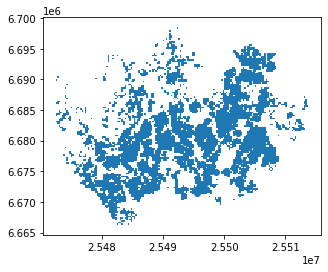

In [6]:
#see that everything is okay
ax =pop.plot()

adr.plot(ax=ax)

<AxesSubplot:>

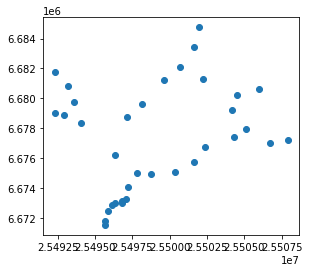

In [7]:
#all to same crs
roads = roads.to_crs(crs=adr.crs)
metro = metro.to_crs(crs = adr.crs)
grid = grid.to_crs(crs = adr.crs)
#see that transport stations look ok
adr.plot()

In [8]:
#create point column needed later in the visualization
adr['points'] = None

adr['points'] = adr['geometry']

adr.head()

,address,id,geometry,points
0,"Kampinkuja 1, 00100 Helsinki, Finland",1001,POINT (25496123.309 6672833.942),POINT (25496123.309 6672833.942)
1,"Kaivokatu 8, 00101 Helsinki, Finland",1002,POINT (25496774.282 6672999.699),POINT (25496774.282 6672999.699)
2,"Hermanstads strandsväg 1, 00580 Helsingfors, F...",1003,POINT (25498746.080 6674947.404),POINT (25498746.080 6674947.404)
3,"Itäväylä, 00900 Helsinki, Finland",1004,POINT (25505098.343 6677972.568),POINT (25505098.343 6677972.568)
4,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",1005,POINT (25495639.560 6671520.343),POINT (25495639.560 6671520.343)


In [9]:
#create 1km buffers from the public transport stations
adr['buffer'] = None

adr['buffer'] = adr.buffer(distance = 1000)

#change geometry column to buffer to do the join
adr['geometry'] = adr['buffer']

#limit to needed columns
adr = adr[['id','geometry','points']]
#join population and public transport stations
join = gpd.sjoin(pop,adr,how ='inner',op='within')

join.head()

,asukkaita,geometry,index_right,id,points
2544,248,"POLYGON ((25491499.998 6681999.002, 25491499.9...",16,1017,POINT (25492349.684 6681772.551)
2545,20,"POLYGON ((25491499.998 6681749.003, 25491499.9...",16,1017,POINT (25492349.684 6681772.551)
2546,439,"POLYGON ((25491499.998 6681499.004, 25491499.9...",16,1017,POINT (25492349.684 6681772.551)
2547,5,"POLYGON ((25491499.998 6681249.005, 25491499.9...",16,1017,POINT (25492349.684 6681772.551)
2596,252,"POLYGON ((25491749.995 6682249.001, 25491749.9...",16,1017,POINT (25492349.684 6681772.551)


In [10]:
#now we have the amount of people living within 1km from public transport station
#we can change geometry back to point to do the visualization
join['geometry'] = join['points']

join.head()

,asukkaita,geometry,index_right,id,points
2544,248,POINT (25492349.684 6681772.551),16,1017,POINT (25492349.684 6681772.551)
2545,20,POINT (25492349.684 6681772.551),16,1017,POINT (25492349.684 6681772.551)
2546,439,POINT (25492349.684 6681772.551),16,1017,POINT (25492349.684 6681772.551)
2547,5,POINT (25492349.684 6681772.551),16,1017,POINT (25492349.684 6681772.551)
2596,252,POINT (25492349.684 6681772.551),16,1017,POINT (25492349.684 6681772.551)


In [11]:
#change crs to wgs84 to work with background map
grid = grid.to_crs(epsg=3857)
join = join.to_crs(epsg=3857)
metro = metro.to_crs(epsg=3857)
join.head()

,asukkaita,geometry,index_right,id,points
2544,248,POINT (2767609.595 8455283.272),16,1017,POINT (25492349.684 6681772.551)
2545,20,POINT (2767609.595 8455283.272),16,1017,POINT (25492349.684 6681772.551)
2546,439,POINT (2767609.595 8455283.272),16,1017,POINT (25492349.684 6681772.551)
2547,5,POINT (2767609.595 8455283.272),16,1017,POINT (25492349.684 6681772.551)
2596,252,POINT (2767609.595 8455283.272),16,1017,POINT (25492349.684 6681772.551)


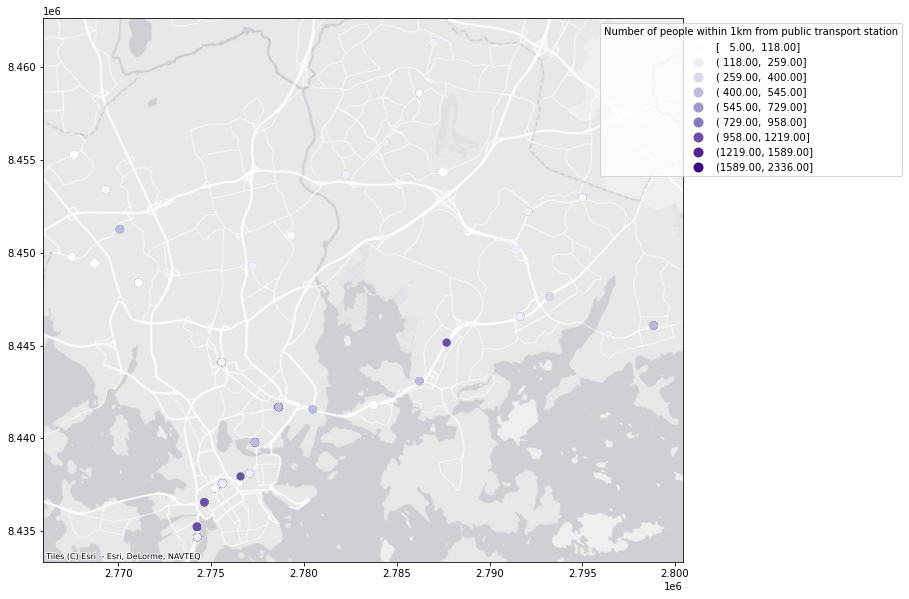

In [26]:
import contextily as ctx
%matplotlib inline

#set fig and axis
fig,ax = plt.subplots(figsize = (20,10))

#plot the public transport stations and classify with 'Natural Breaks'
ax = join.plot(ax=ax,column='asukkaita',
          markersize=50,scheme='NaturalBreaks',k=9,cmap='Purples',legend = True)


#set legend title
ax.get_legend().set_title('Number of people within 1km from public transport station')
#set legend position
ax.get_legend().set_bbox_to_anchor((1.35,1))
#add basemap from Esri
ctx.add_basemap(ax,source=ctx.providers.Esri.WorldGrayCanvas, zoom = 12)
#set output filepath
outfp='static_map.png'
#save to png
plt.savefig(outfp, dpi=300)

INTERACTIVE MAP

I realized after doing the exercise that the exact same map was done in the notebooks.

However my map is coded somewhat different so I did not change it.

In [28]:
import folium 

In [29]:
#create map instance
m = folium.Map(location=[60.25,24.8],zoom_start = 10)

In [30]:
#set pop index in a new column to help with classification
pop['geoid'] = pop.index.astype(str)


In [32]:
#create map instance set 'cartodbpositron' as background map
m = folium.Map(location=[60.25,24.8],zoom_start = 10,tiles='cartodbpositron')




#create Choropleth map from population data
folium.Choropleth(geo_data = pop, #use population data
                  data = pop, 
                  columns=['geoid','asukkaita'], #set columns for unique id and the amount of people living in each grid cell
                  key_on='feature.id', 
                  fill_color='Blues', #set color map to blues
                  line_color='white',#set outline color to white
                  line_weight=0,
                  legend_name= 'Number of inhabitants').add_to(m) #set legend name

#set interactive labels to each grid cell
folium.features.GeoJson(pop, name='Labels',
               style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                tooltip=folium.features.GeoJsonTooltip(fields=['asukkaita'],
                                              aliases = ['Number of inhabitants'],
                                              labels=True,
                                              sticky=False
                                             )
                       ).add_to(m)

#add layercontrol to map instance
folium.LayerControl().add_to(m)
m

outfp = "choropleth_map.html"
m.save(outfp)

LINKS TO THE MAPS

In [ ]:
https://autogis-2021.github.io/exercise-5-mikkokangasmaa/docs/static_map.png
    
https://autogis-2021.github.io/exercise-5-mikkokangasmaa/docs/choropleth_map.html    
    